In [1]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [9]:

# Paths to the folders containing the patches and labels
data_dir = "/data3/animesh/vscode/Kaggle/dataset"
patches_dir = os.path.join(data_dir, "training_patches")
labels_dir = os.path.join(data_dir, "training_noisy_labels")

# Function to load all images in a directory
def load_images_from_folder(folder):
    images = []
    filenames = os.listdir(folder)
    for filename in filenames:
        if filename.endswith(".png"):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path)#.convert('RGB')  # Converting to RGB for consistency
            img = np.array(img)  # Convert to numpy array
            images.append(img)
    return images, filenames

# Load training patches and noisy labels
patches, patch_filenames = load_images_from_folder(patches_dir)
noisy_labels, label_filenames = load_images_from_folder(labels_dir)

# Check if the data has been loaded correctly
print(f"Loaded {len(patches)} patch images.")
print(f"Loaded {len(noisy_labels)} noisy label images.")

# Example: Displaying the shape of the first image and label
print(f"Shape of the first patch: {patches[0].shape}")
print(f"Shape of the first noisy label: {noisy_labels[0].shape}")


Loaded 5000 patch images.
Loaded 5000 noisy label images.
Shape of the first patch: (256, 256, 3)
Shape of the first noisy label: (256, 256)


(256, 256, 3)

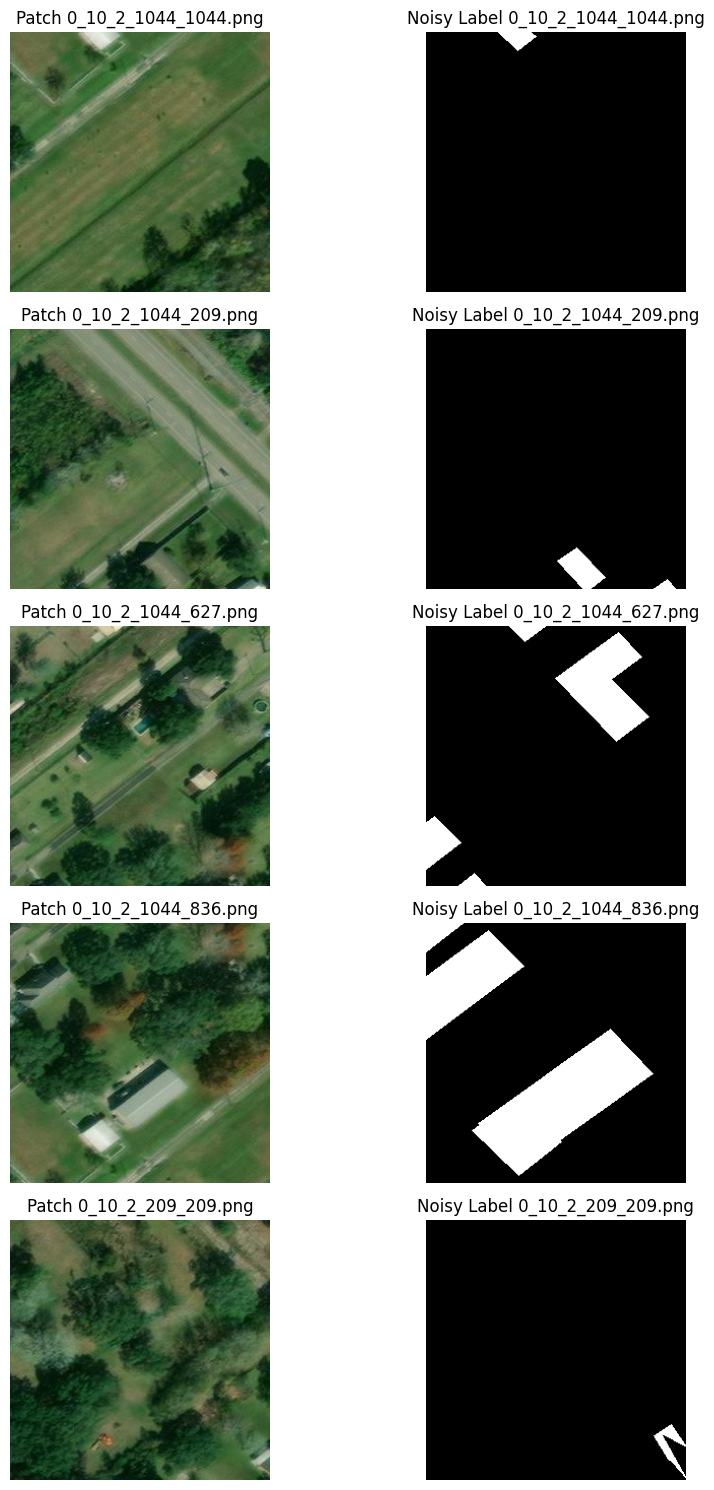

In [10]:
# Function to load image from a file path
def load_image(file_path):
    img = Image.open(file_path)
    return np.array(img)

# Function to visualize patches and their corresponding labels
def visualize_images(patches_dir, labels_dir, num_images=5):
    patch_filenames = sorted(os.listdir(patches_dir))  # Ensure filenames are sorted
    label_filenames = sorted(os.listdir(labels_dir))

    fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images * 3))
    
    for i in range(num_images):
        patch_path = os.path.join(patches_dir, patch_filenames[i])
        label_path = os.path.join(labels_dir, label_filenames[i])
        
        # Load the corresponding patch and label
        patch_img = load_image(patch_path)
        label_img = load_image(label_path)
        
        # Show patch
        axes[i, 0].imshow(patch_img)
        axes[i, 0].set_title(f"Patch {patch_filenames[i]}")
        axes[i, 0].axis('off')
        
        # Show noisy label (in grayscale)
        axes[i, 1].imshow(label_img, cmap='gray')
        axes[i, 1].set_title(f"Noisy Label {label_filenames[i]}")
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize the first 5 images and their corresponding noisy labels
visualize_images(patches_dir, labels_dir, num_images=5)

In [14]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


In [ ]:

# Paths to the dataset
data_dir = "dataset"
patches_dir = os.path.join(data_dir, "training_patches")
labels_dir = os.path.join(data_dir, "training_noisy_labels")

# Load all filenames (sorted to maintain order)
patch_filenames = sorted(os.listdir(patches_dir))  
label_filenames = sorted(os.listdir(labels_dir))

# Split the data into training (4000), validation (500), and testing (500)
train_files, val_test_files = train_test_split(patch_filenames, train_size=4000, random_state=42)
val_files, test_files = train_test_split(val_test_files, test_size=500, random_state=42)

# Define a PyTorch dataset class
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, label_dir, filenames, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.filenames = filenames
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_name = self.filenames[idx]
        
        # Load the image and label
        image_path = os.path.join(self.image_dir, img_name)
        label_path = os.path.join(self.label_dir, img_name)
        
        image = Image.open(image_path).convert("RGB")  # Convert to RGB
        label = Image.open(label_path)  # No need to convert, it's a binary mask
        
        if self.transform:
            image = self.transform(image)
        
        # Convert label to a tensor (grayscale)
        label = torch.from_numpy(np.array(label, dtype=np.float32)).unsqueeze(0)
        
        return image, label

# Define transformations for the images
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensor
])

# Create PyTorch datasets for training, validation, and testing
train_dataset = SegmentationDataset(patches_dir, labels_dir, train_files, transform=transform)
val_dataset = SegmentationDataset(patches_dir, labels_dir, val_files, transform=transform)
test_dataset = SegmentationDataset(patches_dir, labels_dir, test_files, transform=transform)


# Check dataset sizes
print(f"Training set: {len(train_dataset)} images")
print(f"Validation set: {len(val_dataset)} images")
print(f"Test set: {len(test_dataset)} images")


### SAM

In [11]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

/data3/animesh/vscode/Kaggle/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
# Create DataLoader for batch processing
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [18]:
# Fetch one batch from the DataLoader
first_batch = next(iter(test_loader))
batch_X, batch_Y = first_batch

# Print batch details
print("Batch X shape:", batch_X.shape)  # Should be (batch_size, 16, 288, 288)
print("Batch Y shape:", batch_Y.shape)  # Depending on Y_train's shape

Batch X shape: torch.Size([16, 3, 256, 256])
Batch Y shape: torch.Size([16, 1, 256, 256])


In [19]:

# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [20]:
# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [21]:
from torch.optim import Adam
from torch.nn import BCEWithLogitsLoss
from tqdm import tqdm

In [23]:
# Loss function for binary segmentation
loss_fn = BCEWithLogitsLoss()
# Optimizer, only for the trainable mask decoder
optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
# Fine-tuning loop
num_epochs = 1  # Define how many epochs to train
best_val_loss = float('inf')  # Track the best validation loss

In [24]:
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)["mask_logits"]  # Assuming output contains mask logits
        loss = loss_fn(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    print(f"Training Loss: {avg_train_loss}")

Epoch 1/1


  0%|          | 0/250 [00:00<?, ?it/s]


ValueError: Input image size (256*256) doesn't match model (1024*1024).

: 